In [1]:
import os
import sys
import time
import numpy as np
import math
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import skimage.measure
import plyfile
from plyfile import PlyData
from sklearn.neighbors import KDTree
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import trimesh
#from library.cfd_objective import *

In [2]:
print(torch.__version__)
torch.cuda.is_available()

1.1.0


True

In [3]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Nov__3_21:07:56_CDT_2017
Cuda compilation tools, release 9.1, V9.1.85


In [25]:
! nvidia-smi

Mon Aug 10 22:41:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 440.48.02    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:04:00.0 Off |                  N/A |
| 24%   39C    P2    54W / 250W |   3347MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 00000000:05:00.0 Off |                  N/A |
| 23%   24C    P8     8W / 250W |  11875MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
! mkdir networks
! mv ../deep_sdf_decoder.py networks/

In [3]:
def load_latent_vectors(experiment_directory, checkpoint):

    filename = os.path.join(
        experiment_directory, checkpoint + ".pth"
    )
    if not os.path.isfile(filename):
        raise Exception(
            "The experiment directory ({}) does not include a latent code file"
            + " for checkpoint '{}'".format(experiment_directory, checkpoint)
        )
    data = torch.load(filename)
    return data["latent_codes"].cuda()

def load_model(experiment_directory, checkpoint):
    specs_filename = os.path.join(experiment_directory, "specs.json")

    if not os.path.isfile(specs_filename):
        raise Exception(
            'The experiment directory does not include specifications file "specs.json"'
        )

    specs = json.load(open(specs_filename))

    arch = __import__("networks." + specs["NetworkArch"], fromlist=["Decoder"])

    latent_size = specs["CodeLength"]

    decoder = arch.Decoder(latent_size, **specs["NetworkSpecs"])

    decoder = torch.nn.DataParallel(decoder)

    saved_model_state = torch.load(
        os.path.join(experiment_directory, checkpoint + ".pth")
    )

    decoder.load_state_dict(saved_model_state["model_state_dict"])

    decoder = decoder.module.cuda()

    decoder.eval()
    
    return decoder



In [4]:
def create_mesh(
    decoder, latent_vec, filename='', N=256, max_batch=32 ** 3, offset=None, scale=None
):
    ply_filename = filename

    decoder.eval()

    # NOTE: the voxel_origin is actually the (bottom, left, down) corner, not the middle
    voxel_origin = [-1, -1, -1]
    voxel_size = 2.0 / (N - 1)

    overall_index = torch.arange(0, N ** 3, 1, out=torch.LongTensor())
    samples = torch.zeros(N ** 3, 4)

    # transform first 3 columns
    # to be the x, y, z index
    samples[:, 2] = overall_index % N
    samples[:, 1] = (overall_index.long() // N) % N
    samples[:, 0] = ((overall_index.long() // N) // N) % N

    # transform first 3 columns
    # to be the x, y, z coordinate
    samples[:, 0] = (samples[:, 0] * voxel_size) + voxel_origin[2]
    samples[:, 1] = (samples[:, 1] * voxel_size) + voxel_origin[1]
    samples[:, 2] = (samples[:, 2] * voxel_size) + voxel_origin[0]

    num_samples = N ** 3

    samples.requires_grad = False
    head = 0

    while head < num_samples:
        sample_subset = samples[head : min(head + max_batch, num_samples), 0:3].cuda()
        num_subsample = min(max_batch, num_samples-head)
        latent_repeat = latent_vec.expand(num_subsample, -1)
        inputs = torch.cat([latent_repeat, sample_subset], 1)
        samples[head : min(head + max_batch, num_samples), 3] = \
                decoder(inputs).squeeze(1).detach().cpu()
        head += max_batch
        
    sdf_values = samples[:, 3].reshape(N, N, N).data.cpu()

    return convert_sdf_samples_to_ply(
        sdf_values,
        voxel_origin,
        voxel_size,
        ply_filename + ".ply",
        offset,
        scale,
    )

def convert_sdf_samples_to_ply(
    pytorch_3d_sdf_tensor,
    voxel_grid_origin,
    voxel_size,
    ply_filename_out,
    offset=None,
    scale=None,
):
    """
    Convert sdf samples to .ply

    :param pytorch_3d_sdf_tensor: a torch.FloatTensor of shape (n,n,n)
    :voxel_grid_origin: a list of three floats: the bottom, left, down origin of the voxel grid
    :voxel_size: float, the size of the voxels
    :ply_filename_out: string, path of the filename to save to

    This function adapted from: https://github.com/RobotLocomotion/spartan
    """

    numpy_3d_sdf_tensor = pytorch_3d_sdf_tensor.numpy()

    verts, faces, normals, values = skimage.measure.marching_cubes_lewiner(
        numpy_3d_sdf_tensor, level=0.0, spacing=[voxel_size] * 3
    )

    # transform from voxel coordinates to camera coordinates
    # note x and y are flipped in the output of marching_cubes
    mesh_points = np.zeros_like(verts)
    mesh_points[:, 0] = voxel_grid_origin[0] + verts[:, 0]
    mesh_points[:, 1] = voxel_grid_origin[1] + verts[:, 1]
    mesh_points[:, 2] = voxel_grid_origin[2] + verts[:, 2]

    # apply additional offset and scale
    if scale is not None:
        mesh_points = mesh_points / scale
    if offset is not None:
        mesh_points = mesh_points - offset

    # try writing to the ply file

    num_verts = verts.shape[0]
    num_faces = faces.shape[0]

    verts_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])
    norms_tuple = np.zeros((num_verts,), dtype=[("x", "f4"), ("y", "f4"), ("z", "f4")])

    for i in range(0, num_verts):
        verts_tuple[i] = tuple(mesh_points[i, :])
        norms_tuple[i] = tuple(normals[i, :])

    faces_building = []
    for i in range(0, num_faces):
        faces_building.append(((faces[i, :].tolist(),)))
    faces_tuple = np.array(faces_building, dtype=[("vertex_indices", "i4", (3,))])

    el_verts = plyfile.PlyElement.describe(verts_tuple, "vertex")
    el_faces = plyfile.PlyElement.describe(faces_tuple, "face")
    el_norms = plyfile.PlyElement.describe(norms_tuple, "normals")

    ply_data = plyfile.PlyData([el_verts, el_faces, el_norms])
    return ply_data

In [5]:
def transformPoints(points, AvgTransform):
    matrix = torch.cuda.FloatTensor(AvgTransform)
    column = torch.ones((len(points), 1), device="cuda:0") 
    stacked = torch.cat([points, column], dim=1)
    transformed = torch.matmul(matrix, stacked.t()).t()[:, :3]
    return transformed

def transform_mesh(points, ply_mesh, AvgTransform):
    #transformed_points = transformPoints(points, AvgTransform)
    #print(transformed_points.shape)
    edges = trimesh.geometry.faces_to_edges(ply_mesh['face']['vertex_indices'])
    np_points = points.cpu().detach().numpy()
    edge_attr = [np_points[a] - np_points[b] for a, b in edges]
    mesh = {'x': points, 
        'face': ply_mesh['face']['vertex_indices']
        }
    return mesh

In [6]:
def compute_lift_faces_diff(mesh, preds):
    #pressure = preds[mesh['face'], 0].mean(dim=1)

    # TODO: cahnge to x if needed
    pos = mesh['x']
    cross_prod = (pos[mesh['face'][:,1]] - pos[mesh['face'][:,0]]).cross( 
                  pos[mesh['face'][:,2]] - pos[mesh['face'][:,0]])
    area = -cross_prod / 2
    #lift = torch.mul(pressure, area)
    lift = area
    return torch.sum(lift[~torch.isnan(lift)]), area

In [9]:
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

/home/qiu/miniconda3/envs/meshSDF/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:125: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "


## initilisation

In [7]:
DIR_for_dump_data = './starting_data'
experiment_directory = DIR_for_dump_data



decoder = load_model(experiment_directory, "decoderModel")
latent_vectors = load_latent_vectors(experiment_directory, "latentCodes")
latent_vectors = latent_vectors.detach()

LATENT_TO_OPTIMIZE = latent_vectors[32]
LATENT_KD_TREE = KDTree(np.array([lv.cpu().detach().numpy()[0] for lv in latent_vectors]))
AvgTransform = np.load(DIR_for_dump_data + "/avg_trans_matrix.npy") #computeAvgTransform()


## check sum of directed surface area is zero

In [8]:
field = np.load("Expirements/OptimizationPaper/predictions/00001.npy", allow_pickle=True)
field = torch.tensor(field).cuda()

initial_la = latent_vectors[32]
ply_mesh = create_mesh(decoder,
                        initial_la,
                        N=128,
                        max_batch=int(2 ** 12))

points = torch.tensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                            ply_mesh['vertex']['y'][:, None], 
                                            ply_mesh['vertex']['z'][:, None]))).cuda()
mesh_dic = {'x': points, 
            'face': ply_mesh['face']['vertex_indices']}

In [9]:
print(field.shape)
print(mesh_dic['face'].shape)
print(mesh_dic['x'].shape)

torch.Size([99888, 4])
(48928, 3)
torch.Size([24458, 3])


In [10]:
cross_prod = (points[mesh_dic['face'][:,1]] - points[mesh_dic['face'][:,0]]).cross( 
              points[mesh_dic['face'][:,2]] - points[mesh_dic['face'][:,0]])
area_full = -cross_prod / 2
area_full.sum(dim=0)

tensor([ 1.0186e-09, -4.8894e-09, -2.7940e-09], device='cuda:0')

In [11]:
area_full[area_full[:,0]>0].sum(dim=0)

tensor([ 0.5345,  0.4560, -0.0141], device='cuda:0')

In [12]:
area_full.norm(dim=1).sum()

tensor(5.0062, device='cuda:0')

## check directed and undirected surface area uncharge w.r.t. resolution

In [17]:
for n in [8, 16, 32, 64, 128, 200, 256]:

    ply_mesh = create_mesh(decoder,
                            initial_la,
                            N=n,
                            max_batch=int(2 ** 10))
    points = torch.tensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                            ply_mesh['vertex']['y'][:, None], 
                                            ply_mesh['vertex']['z'][:, None]))).cuda()
    mesh_dic = {'x': points, 
                'face': ply_mesh['face']['vertex_indices']}
    cross_prod = (points[mesh_dic['face'][:,1]] - points[mesh_dic['face'][:,0]]).cross( 
              points[mesh_dic['face'][:,2]] - points[mesh_dic['face'][:,0]])
    area = -cross_prod / 2
    print("N=%d, s=%f"%(n, area.norm(dim=1).sum()))
    print("directed area = {} \n".format(area.sum(dim=0)))
    

N=8, s=3.177701
directed area = tensor([ 1.1176e-08, -1.8626e-08, -1.4901e-08], device='cuda:0') 

N=16, s=4.142625
directed area = tensor([0.0000e+00, 1.8626e-09, 2.9802e-08], device='cuda:0') 

N=32, s=4.642710
directed area = tensor([-2.3283e-09, -4.6566e-09,  0.0000e+00], device='cuda:0') 

N=64, s=4.909176
directed area = tensor([2.7940e-09, 2.7008e-08, 7.4506e-09], device='cuda:0') 

N=128, s=5.006247
directed area = tensor([ 2.4156e-09, -4.1910e-09, -1.8626e-09], device='cuda:0') 

N=200, s=5.027665
directed area = tensor([ 2.7940e-09,  7.4506e-09, -4.6566e-10], device='cuda:0') 

N=256, s=5.034421
directed area = tensor([ 9.3132e-10,  3.7253e-09, -2.1828e-10], device='cuda:0') 



### show front faces

In [13]:
mixed_face = (points[mesh_dic['face'][:,0]] + points[mesh_dic['face'][:,1]] + points[mesh_dic['face'][:,2]])/3
mixed_array = mixed_face.cpu().numpy()
front_half_faces_indices = np.array(np.where(mixed_array[:,0]>0))
front_half_faces_vertices_indices = mesh_dic['face'][front_half_faces_indices]

front0 = front_half_faces_vertices_indices[0, :, 0]
front1 = front_half_faces_vertices_indices[0, :, 1]
front2 = front_half_faces_vertices_indices[0, :, 2]
front = np.array(list(set(front0).union(set(front1)).union(set(front2))))

In [31]:
#mixed_array[front_half_faces_indices]

In [22]:
# this is the pressure on front half of car
area_full[front_half_faces_indices].sum(dim=0)

tensor([-3.3219e-01, -2.9104e-09,  9.3132e-10], device='cuda:0')

In [21]:
area_full.sum(dim=0)

tensor([ 1.0186e-09, -4.8894e-09, -2.7940e-09], device='cuda:0')

In [26]:
color = np.zeros(points.shape[0])
color[front] = 1
color = color * 8 - 4

In [24]:
def get_trimesh_from_torch_geo_with_colors(mesh, color, vmin=-8, vmax=8):
    norm = mpl.colors.Normalize(vmin= vmin, vmax=vmax)
    cmap = cm.hot
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    verticies = mesh['x'].cpu().detach()
    faces = mesh['face']
    return trimesh.Trimesh(vertices=verticies, faces=faces, 
                           vertex_colors=list(map(lambda c: m.to_rgba(c), color)))

In [28]:
#tri_mesh = get_trimesh_from_torch_geo_with_colors(mesh_dic, color)
#tri_mesh.show()

### faces toward back 

In [37]:
backward_faces_vertices_indices.shape

(24579, 3)

In [38]:
backward_faces_indices = np.where(area_full.cpu().numpy()[:,0]<0)[0]
backward_faces_vertices_indices = mesh_dic['face'][backward_faces_indices]

back0 = backward_faces_vertices_indices[:, 0]
back1 = backward_faces_vertices_indices[:, 1]
back2 = backward_faces_vertices_indices[:, 2]
back = np.array(list(set(back0).union(set(back1)).union(set(back2))))

In [40]:
colorB = np.zeros(points.shape[0])
colorB[back] = 1
colorB = colorB * 8 - 4

In [39]:
# this is the pressure on front half of car
area_full[backward_faces_indices].sum(dim=0)

tensor([-0.5345, -0.4561,  0.0141], device='cuda:0')

In [42]:
#tri_meshB = get_trimesh_from_torch_geo_with_colors(mesh_dic, colorB)
#tri_meshB.show()

### statistics of pressure 

In [63]:
#mesh_dic['face']

In [64]:
#points

In [66]:
#np.where(field[:,0].cpu().numpy() < 0)

In [65]:
#np.where(field[:,0].cpu().numpy() > 0)

In [56]:
field[:int(99888/2), 0].mean()

tensor(-0.1928, device='cuda:0')

In [55]:
field[int(99888/2):, 0].mean()

tensor(-0.1089, device='cuda:0')

### check pressure field and mesh

In [76]:
field0 = np.load("Expirements/OptimizationPaper/predictions/00000.npy", allow_pickle=True)

In [71]:
mesh0 = trimesh.load_mesh("Expirements/OptimizationPaper/meshes/00000.ply")

In [77]:
norm = mpl.colors.Normalize(vmin=-8, vmax=8)
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)

tri_mesh0 = trimesh.Trimesh(vertices=mesh0.vertices, faces=mesh0.faces, 
                       vertex_colors=list(map(lambda c: m.to_rgba(c), field0[:,0])))

In [79]:
#tri_mesh0.show()

In [49]:
pressure = field[mesh_dic['face'], 0].mean(dim=1)

In [111]:
AvgTransform

array([[-5.31859338e-01,  0.00000000e+00,  0.00000000e+00,
        -4.89233836e-02],
       [ 0.00000000e+00,  5.31859338e-01,  0.00000000e+00,
         1.75338480e-02],
       [ 0.00000000e+00,  0.00000000e+00, -5.31859338e-01,
        -3.49366102e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

# need pytorch geometric

In [ ]:
import torch_geometric
from torch_geometric.nn import (NNConv, GMMConv, GraphConv, Set2Set)
from torch_geometric.nn import (SplineConv, graclus, max_pool, max_pool_x, global_mean_pool)

model = SplineCNN8Residuals(3)
model.load_state_dict(torch.load(experiment_directory + "/cfdModel.nn"))
model = model.to("cuda:0")
model = model.eval()

## step by step: from latent to loss

In [114]:
initial_la = latent_vectors[32]
ply_mesh = create_mesh( decoder,
                        initial_la,
                        N=8,
                        max_batch=int(2 ** 18),
                        offset=None,
                        scale=None)

In [9]:
points = torch.cuda.FloatTensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                            ply_mesh['vertex']['y'][:, None], 
                                            ply_mesh['vertex']['z'][:, None])))

# from mesh to pressure field
points.requires_grad = True
mesh = make_mesh_from_points(points, ply_mesh)

In [ ]:
#del ply_mesh, points
local_preds = model(mesh)
loss = calculate_loss(mesh, local_preds, axis=0, constraint_rad=0.05)

In [ ]:
loss.backward()
dL_dp = points.grad.clone()

In [ ]:
points.grad.data.zero_()
sdf_value = decode_sdf(decoder, initial_la, points)
sdf_value.backward(torch.ones([len(points), 1], dtype=torch.float32).cuda())

In [ ]:
# assemble constant 
mults = [-p1.dot(p2) for p1, p2 in zip(dL_dp, points.grad)]       
multipliers = torch.cuda.FloatTensor(mults)

In [ ]:
points = points.detach()
initial_la = initial_la.detach().requires_grad_(True)
latent_inputs = initial_la.expand(points.shape[0], -1)
inputs = torch.cat([latent_inputs, points], 1).cuda() 
sdf_value = decoder(inputs)
final_loss = torch.sum(sdf_value.squeeze() * multipliers)
final_loss.backward()

In [ ]:
#initial_la.grad

In [ ]:
#initial_la.grad.data.zero_()

In [ ]:
apenalty = soft_constraints(initial_la, latent_vectors, num_neignours_constr=10, alpha_penalty=0.2)
apenalty.backward()

In [ ]:
#initial_la.grad

In [ ]:
final_loss

In [ ]:
penalty

In [ ]:
innerBoundsLoss(mesh['x'], r=(0.5 / 2)**2, center=(0.3, 0, 0))

In [ ]:
boundsLoss(mesh['x'], box=[(-0.006, 0.006, 0)])

In [ ]:
local_preds[0]

In [ ]:
points.shape

In [ ]:
ply_mesh.write("data_for_this_experiments/mesh32.ply")

In [ ]:
# from latent to mesh/point
with torch.no_grad():
    ply_mesh = create_mesh( decoder,
                            latent,
                            N=N,
                            max_batch=int(2 ** 18),
                            offset=None,
                            scale=None)
points = torch.cuda.FloatTensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                            ply_mesh['vertex']['y'][:, None], 
                                            ply_mesh['vertex']['z'][:, None])))

# from mesh to pressure field
points.requires_grad = True
mesh = make_mesh_from_points(points, ply_mesh)
local_preds = model(mesh)
loss = calculate_loss(mesh, local_preds, axis=axis, constraint_rad=constraint_rad)



loss.backward()
dL_dp = points.grad.clone()





# calculate mesh normal
points.grad.data.zero_()
sdf_value = decode_sdf(decoder, latent, points)
sdf_value.backward(torch.ones([len(points), 1], dtype=torch.float32).cuda())

# assemble constant 
mults = [-p1.dot(p2) for p1, p2 in zip(dL_dp, points.grad)]       
multipliers = torch.cuda.FloatTensor(mults)



# get gradient of sdf w.r.t. latent
#optimizer.zero_grad()
latent.grad.data.zero_()
sdf_value = torch.squeeze(.decode_sdf(decoder, latent, points))
final_loss = torch.sum(sdf_value * multipliers)
final_loss.backward()

# artificial loss
apenalty = soft_constraints(latent, latent_vectors, num_neignours_constr)
apenalty.backward()

#print("Latent grad penalized: ", torch.sum(latent.grad ** 2))

#optimizer.step()

In [7]:
def method4_to_arbitatry_loss(points, ply_mesh, model, constraint_rad=0.1, axis=0):
    initial_dir = points.grad.clone()
    points.grad.data.zero_()

    mesh = make_mesh_from_points(points, ply_mesh)
    #signs = compute_signs_for_loss(mesh, transformPoints(normals, AvgTransform))
    local_preds = model(mesh)
    loss = calculate_loss(mesh, local_preds, axis=axis, constraint_rad=constraint_rad)
    loss.backward()

    sign = [-p1.dot(p2) for p1, p2 in zip(initial_dir, points.grad)]
    
    return sign, loss, local_preds, mesh



def optimize_shape_deepSDF(decoder, latent, initial_points=None, num_points=None, 
                           num_iters=100, point_iters=100, num_neignours_constr=10,
                           lr=0.2, decreased_by=2, adjust_lr_every=10, alpha_penalty=0.05,
                           multiplier_func=method4_to_arbitatry_loss, verbose=None, save_to_dir=None, N=256):

    def adjust_learning_rate(
        initial_lr, optimizer, num_iterations, decreased_by, adjust_lr_every
    ):
        lr = initial_lr * ((1 / decreased_by) ** (num_iterations // adjust_lr_every)) \
                        * ((punch_lr_at_reindex_by) ** (num_iterations // reindex_latent_each))
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
            
        return lr
    
    if not os.path.exists(os.path.join(save_to_dir, 'meshes')):
        os.makedirs(os.path.join(save_to_dir, 'meshes'))
    if not os.path.exists(os.path.join(save_to_dir, 'predictions')):
        os.makedirs(os.path.join(save_to_dir, 'predictions'))

    ref_latent = latent.clone().detach()
    decoder.eval()
    latent = latent.clone()
    latent.requires_grad = True
    optimizer = torch.optim.SGD([latent], lr=lr)

    loss_plot = []
    latent_dist = []
    lr_plot = []
    latent_plot = []

    for i in range(num_iters):

        time_start = time.time()

        save_path = os.path.join(save_to_dir, 'meshes/' + str(i).zfill(5) + ".ply")
        preds_save_path = os.path.join(save_to_dir, 'predictions/' + str(i).zfill(5) + ".npy")


        cur_rl = adjust_learning_rate(lr, optimizer, i, decreased_by, adjust_lr_every)

        with torch.no_grad():
            ply_mesh = create_mesh( decoder,
                                    latent,
                                    N=N,
                                    max_batch=int(2 ** 18),
                                    offset=None,
                                    scale=None)

        points = torch.cuda.FloatTensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                                    ply_mesh['vertex']['y'][:, None], 
                                                    ply_mesh['vertex']['z'][:, None])))

        points.requires_grad = True

        sdf_value = decode_sdf(decoder, latent, points)
        sdf_value.backward(torch.ones([len(points), 1], dtype=torch.float32).cuda())

        mults, loss_value, preds, transformed_mesh = multiplier_func(points, ply_mesh)         
        multipliers = torch.cuda.FloatTensor(mults)

        optimizer.zero_grad()
        sdf_value = torch.squeeze(decode_sdf(decoder, latent, points))

        final_loss = torch.sum(sdf_value * multipliers)
        final_loss.backward()

        # Soft-constraints
        distances, indeces = LATENT_KD_TREE.query(latent.cpu().detach(), k=num_neignours_constr)
        penalty = torch.mean(
                    torch.stack([torch.sum( 
                                    (latent - latent_vectors[indeces[0][i]]) ** 2
                                 )
                                 for i in range(len(indeces[0]))]
                               )
                    )
        apenalty = penalty * alpha_penalty
        apenalty.backward()


        optimizer.step()
       

        tri_mesh = get_trimesh_from_torch_geo_with_colors(transformed_mesh, preds)
        tri_mesh.export(save_path)
        #np.save(preds_save_path, preds.cpu().detach().numpy())

        #if save_to_dir is not None:
        #    plot_points_from_torch

        loss_plot.append(loss_value.cpu().detach().numpy())
        latent_dist.append(torch.sum((latent - ref_latent) ** 2 ).cpu().detach().numpy() )
        latent_plot.append(latent.detach().cpu().numpy())
        lr_plot.append(penalty)

        time_end = time.time()

        if verbose is not None and i % verbose == 0:
            print('Iter ', i, 'Loss: ', loss_value.detach().cpu().numpy(), ' LD: ', lr_plot[-1])
            print("backward loss: ", final_loss)
            print("penality: ", apenalty)
            print("together: ", apenalty + final_loss, "\n")
    
        np.save(os.path.join(save_to_dir, "latent_plot.npy"), latent_plot)    
        np.save(os.path.join(save_to_dir, "loss_plot.npy"), loss_plot)
        np.save(os.path.join(save_to_dir, "latent_dist.npy"), latent_dist)
        np.save(os.path.join(save_to_dir, "lr_plot.npy"), lr_plot)



def make_full_transformation(initial_latent, experiment_name, 
                             decoder, model, alpha_penalty=0.05, constraint_rad=0.1, axis=0, **kwargs):
    '''
    kwargs:
        num_iters=1000, 
        adjust_lr_every=10, 
        decreased_by=1.2,
        lr=0.005
        verbose=10,
    '''

    #ref_points = get_points_from_latent(decoder, ref_latent, N=128)
    save_to_dir = experiment_name
    if not os.path.exists(save_to_dir):
        os.makedirs(save_to_dir)

    #np.save(os.path.join(save_to_dir, "target_verts.npy"), ref_points)

    optimize_shape_deepSDF(decoder, initial_latent, initial_points=None,
                                           alpha_penalty=alpha_penalty,
                                           num_points=None, point_iters=2,
                                           multiplier_func=lambda x, y: 
                                               method4_to_arbitatry_loss(x, y, model, 
                                                                         constraint_rad=constraint_rad, 
                                                                         axis=axis),
                                           save_to_dir=save_to_dir, **kwargs)
   

In [8]:

DIR_for_dump_data = './data_for_this_experiments'
punch_lr_at_reindex_by=1
reindex_latent_each = 10000


In [ ]:
np.random.seed(101)
make_full_transformation(LATENT_TO_OPTIMIZE.detach(),
                         experiment_name=DIR_for_dump_data, decoder=decoder, model=model,
                         alpha_penalty=0.2, axis=0,
                         constraint_rad=0.05,
                         num_iters=3,
                         adjust_lr_every=20,
                         decreased_by=1.1, 
                         lr=0.2,
                         verbose=1,
                         N=256,
                         num_neignours_constr=10)

In [2]:
#preds = np.load("data_for_this_experiments/OptimizationPaper/predictions/00000.npy")
mesh = trimesh.load_mesh("data_for_this_experiments/meshes/00029.ply")
loss_plot = np.load("data_for_this_experiments/loss_plot.npy", allow_pickle=True)
lr_plot = np.load("data_for_this_experiments/lr_plot.npy", allow_pickle=True)
latent_plot = np.load("data_for_this_experiments/latent_plot.npy", allow_pickle=True)

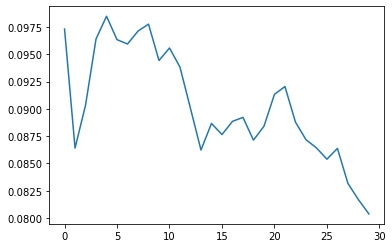

In [3]:
plt.plot(loss_plot)

In [ ]:
distances, indeces = LATENT_KD_TREE.query(torch.tensor(latent_plot[-1]), k=10)

In [ ]:
indeces

In [ ]:
newl = 0.1 * latent_vectors[indeces.squeeze()[0]] + 0.9 * latent_vectors[indeces.squeeze()[1]]

In [ ]:
#visual_Mesh(torch.tensor(newl)).show()

In [ ]:
#visual_Mesh(torch.tensor(latent_vectors[indeces.squeeze()[:2]].mean(axis=0))).show()

In [ ]:
#visual_Mesh(torch.tensor(latent_vectors[indeces].mean(axis=0))).show()

In [ ]:
#visual_Mesh(latent_vectors[267]).show()

In [ ]:
#visual_Mesh(latent_vectors[350]).show()

In [ ]:
#visual_Mesh(torch.tensor(latent_plot[-1]).cuda()).show()

In [ ]:
#plt.plot(lr_plot)

In [ ]:
mesh = trimesh.load_mesh("data_for_this_experiments/meshes/00004.ply")
#mesh.show()

In [ ]:
mesh = trimesh.load_mesh("data_for_this_experiments/meshes/00029.ply")
#mesh.show()

In [ ]:
distances, indeces = LATENT_KD_TREE.query(LATENT_TO_OPTIMIZE.cpu().detach(), k=10)

In [ ]:
mesh['face'].shape

In [ ]:
torch.norm(latent_vectors[indeces.squeeze()[0]] - latent_vectors[indeces.squeeze()[8]])

In [ ]:
torch.norm(latent_vectors[indeces.squeeze()[9]] - latent_vectors[indeces.squeeze()[8]])

In [ ]:
torch.norm(latent_vectors[indeces.squeeze()[7]] - latent_vectors[indeces.squeeze()[8]])

In [ ]:

def visual_Mesh(ilatent):
    ply_mesh = create_mesh(decoder,
                        ilatent,
                        N=256,
                        max_batch=int(2 ** 18))
    points = torch.cuda.FloatTensor(np.hstack(( ply_mesh['vertex']['x'][:, None], 
                                            ply_mesh['vertex']['y'][:, None], 
                                            ply_mesh['vertex']['z'][:, None])))
    scaled_mesh = make_mesh_from_points(points, ply_mesh)
    pressure_field = model(scaled_mesh)
    loss = compute_lift_faces_diff(scaled_mesh, pressure_field, axis=0)  
    print("latent loss. %f "%(loss))
    return get_trimesh_from_torch_geo_with_colors(scaled_mesh, pressure_field)
    

In [ ]:
#visual_Mesh(latent_vectors[26]).show() # 

In [ ]:
mesh37 = trimesh.load_mesh("Expirements/OptimizationPaper/meshes/00037.ply")
mesh37.show()


In [ ]:
mesh = {'point_pos': tansformed_points, 
        'edge_vec':torch.tensor(edge_attr, dtype=torch.float).to('cuda:0'),
        'edge_index':torch.tensor(edges, dtype=torch.long).t().contiguous().to('cuda:0')
        }

In [27]:
compute_lift_faces_diff(mesh, torch.tensor(pressure).cuda())

torch.Size([2824])
torch.Size([2824])


tensor(-0.1377, device='cuda:0', grad_fn=<SumBackward0>)